C:\Users\Dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\Dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the 

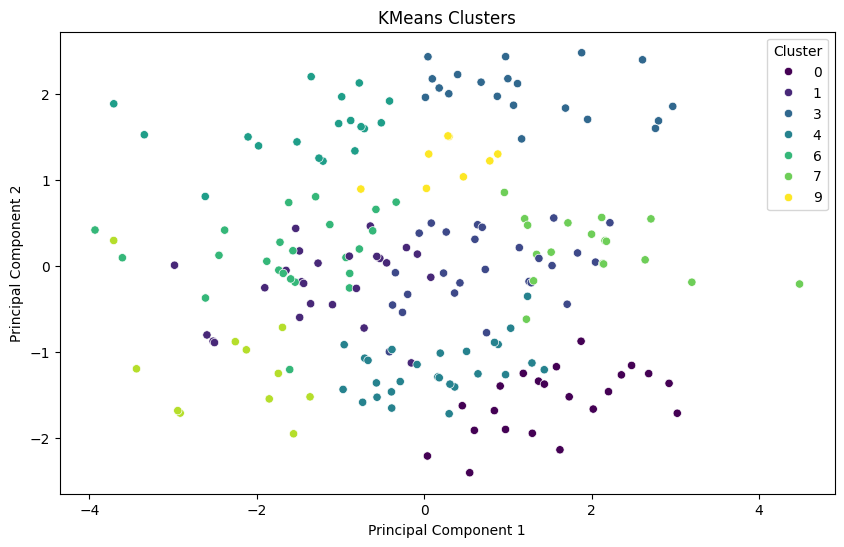

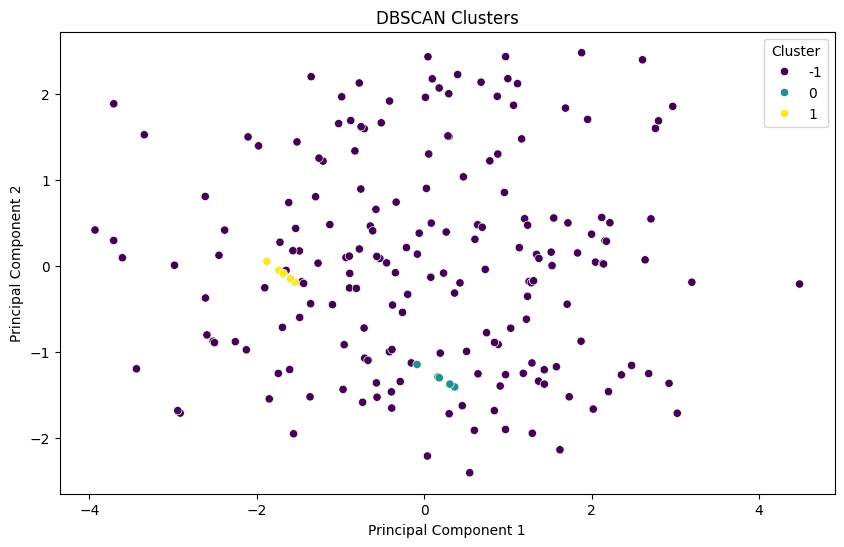

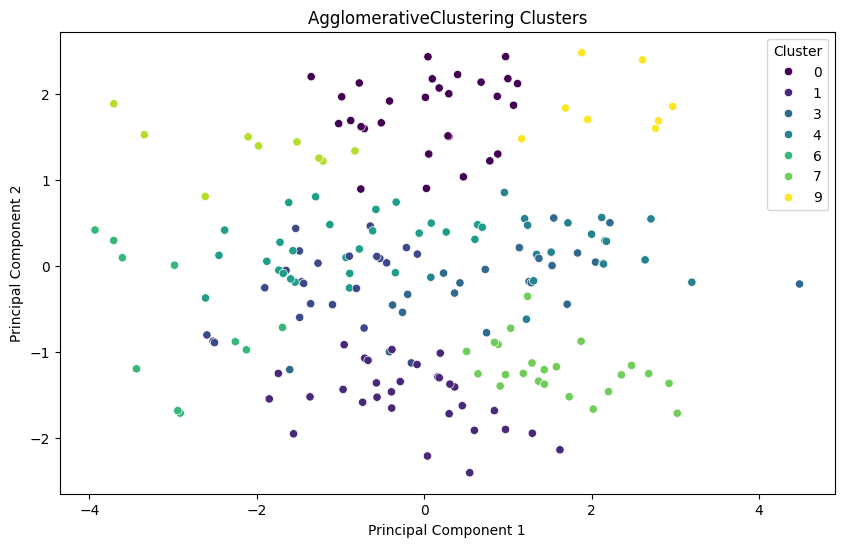

Optimal Number of Clusters for KMeans: 10
DB Index for KMeans with 10 clusters: 1.0173792115093776
Silhouette Score for KMeans with 10 clusters: 0.31491451086712197
Optimal Number of Clusters for DBSCAN: 2
DB Index for DBSCAN with 2 clusters: 1.4329791040426023
Silhouette Score for DBSCAN with 2 clusters: -0.21036526424055177
Optimal Number of Clusters for AgglomerativeClustering: 7
DB Index for AgglomerativeClustering with 7 clusters: 1.1286874133073799
Silhouette Score for AgglomerativeClustering with 7 clusters: 0.29542187479126014


In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import seaborn as sns

transactions = pd.read_csv('Transactions.csv') 
customers = pd.read_csv('Customers.csv')
products = pd.read_csv('Products.csv')

# Merge datasets
transactions_products = pd.merge(transactions, products,on='ProductID', how='left')
merged_data = pd.merge(transactions_products, customers, on='CustomerID', how='left')






customer_features = merged_data.groupby('CustomerID').agg(
    total_spent=('TotalValue','sum'),
    purchase_frequency=('TransactionID', 'count'),
    unique_categories=('Category',lambda x: x.nunique()),
    avg_order_value=('TotalValue','mean'),
    gender=('Region','first'), 
).reset_index()

# One-Hot Encoding for categorical variables like Region
encoder = OneHotEncoder(drop='first', sparse=False)
encoded_cats = encoder.fit_transform(customer_features[['gender']])
encoded_cats_df = pd.DataFrame(encoded_cats, columns=encoder.get_feature_names_out())



final_features = pd.concat([customer_features.drop(['gender', 'CustomerID'], axis=1), encoded_cats_df], axis=1)
scaler = StandardScaler()
normalized_data = scaler.fit_transform(final_features)

# Clustering algorithms
clustering_algorithms = {
    "KMeans": KMeans(),
    "DBSCAN": DBSCAN(),
    "AgglomerativeClustering": AgglomerativeClustering()
}

dbi_scores = {
    "KMeans": [],
    "DBSCAN": [],
    "AgglomerativeClustering": []
}
silhouette_scores = {
    "KMeans": [],
    "DBSCAN": [],
    "AgglomerativeClustering": []
}


range_n_clusters = range(2, 11)  # 2 to 10 clusters


for algorithm_name, algorithm in clustering_algorithms.items():
    for n_clusters in range_n_clusters:
        if algorithm_name == "KMeans":
            algorithm.set_params(n_clusters=n_clusters)
        elif algorithm_name == "AgglomerativeClustering":
            algorithm.set_params(n_clusters=n_clusters)
        
        # Fit the model
        labels = algorithm.fit_predict(normalized_data)
        
        # Calculate metrics only for KMeans and AgglomerativeClustering 
        if algorithm_name !="DBSCAN":
            dbi = davies_bouldin_score(normalized_data, labels)
            silhouette = silhouette_score(normalized_data, labels)
            dbi_scores[algorithm_name].append(dbi)
            silhouette_scores[algorithm_name].append(silhouette)
        else:
            # DBSCAN don't require number of clusters and has other parameters
            dbi = davies_bouldin_score(normalized_data, labels)
            silhouette = silhouette_score(normalized_data, labels)
            dbi_scores[algorithm_name].append(dbi)
            silhouette_scores[algorithm_name].append(silhouette)

# Visualize the clustering results using PCA for dimensionality reduction
for algorithm_name, algorithm in clustering_algorithms.items():
    labels = algorithm.fit_predict(normalized_data)
#   pca 
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(normalized_data)
    reduced_df = pd.DataFrame(reduced_data, columns=['PC1', 'PC2'])
    reduced_df['Cluster'] = labels

# Plotting the custer
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=reduced_df, palette='viridis')
    plt.title(f'{algorithm_name} Clusters')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(title='Cluster')
    plt.show()




for algorithm_name in clustering_algorithms.keys():
    best_cluster_count = range_n_clusters[np.argmin(dbi_scores[algorithm_name])]
    print(f"Optimal Number of Clusters for {algorithm_name}: {best_cluster_count}")
    print(f"DB Index for {algorithm_name} with {best_cluster_count} clusters: {min(dbi_scores[algorithm_name])}")
    print(f"Silhouette Score for {algorithm_name} with {best_cluster_count} clusters: {silhouette_scores[algorithm_name][np.argmin(dbi_scores[algorithm_name])]}")
